# Applied Deep Learning Assignment Task 1
`Name: Gangula Karthik`<br>
`Admin_no: 223715Y`

---

_**Develop and compare deep learning and transfer learning models for early brain tumor detection and classification to optimize treatment selection and improve patient outcomes.**_

---


## Table of Contents
1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Data Validation and Cleaning](#Data-Validation-and-Cleaning)
1. [Train Test Split](#Train-Test-Split)
1. [Numerical EDA](#Numerical-EDA)
1. [Graphical EDA](#Graphical-EDA)
1. [Feature Engineering](#Feature-Engineering)
1. [Data Preprocessing](#Data-Preprocessing)
1. [Baseline Model](#Baseline-Model)
1. [Model Building, Selection, and Evaluation](#Model-Building-Selection-and-Evaluation)
1. [Baseline Model Comparison](#Baseline-Model-Comparison)
1. [Final Model Evaluation](#Final-Model-Evaluation)
1. [Conclusion](#Conclusion)
1. [Appendix](#Appendix)

---


### Introduction

Brain tumors are abnormal growths within or around the brain that can be malignant or benign, requiring accurate and early diagnosis for effective treatment. Distinguishing brain tumors from other cystic or tumor-like growths in MRI scans remains a significant challenge in medical imaging. Advanced deep learning techniques offer the potential to enhance early detection and diagnosis, reducing misclassification and improving patient outcomes. Based on their location and origin, brain tumors can be categorized into types such as Gliomas, which originate in the brain or spinal cord; Meningiomas, arising from the protective membranes (meninges) surrounding the brain and spinal cord; and Pituitary Tumors, which develop in the pituitary gland. Developing deep learning-based models to differentiate between these tumor types and similar-appearing cysts in MRI scans is crucial for guiding timely and appropriate treatment strategies.

---

### Setup

Import all the Python libraries we will need

---

In [74]:
# Add imports here
import itertools
import pandas as pd
import cv2
import random
from ydata_profiling import ProfileReport
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import os
import scipy.stats
import tensorflow as tf
from tqdm import tqdm
import phik
import tensorflow as tf
from tensorflow.keras.regularizers import l2
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

### Loading the datasets

Parsing the folders and putting them in a dataframe.

---

In [50]:
dataset_path = "/kaggle/input/brain-tumor-mri-dataset"
train_dir = os.path.join(dataset_path, "Training")
test_dir = os.path.join(dataset_path, "Testing")

In [51]:
def create_dataframe(directory):
    data = []
    for label in os.listdir(directory): 
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):  
            for img_file in os.listdir(label_path):  
                img_path = os.path.join(label_path, img_file)
                data.append((img_path, label))
    return pd.DataFrame(data, columns=["file_path", "label"])

train_df = create_dataframe(train_dir)
test_df = create_dataframe(test_dir)

In [52]:
display("Train DataFrame:", train_df.head())
display("Test DataFrame:", test_df.head())

'Train DataFrame:'

file_path      label
0  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
1  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
2  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
3  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
4  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary

'Test DataFrame:'

file_path      label
0  /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
1  /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
2  /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
3  /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
4  /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary

### Data Understanding

Analysing the data in depth in order to understand the data and how to apply different transformations. 

---

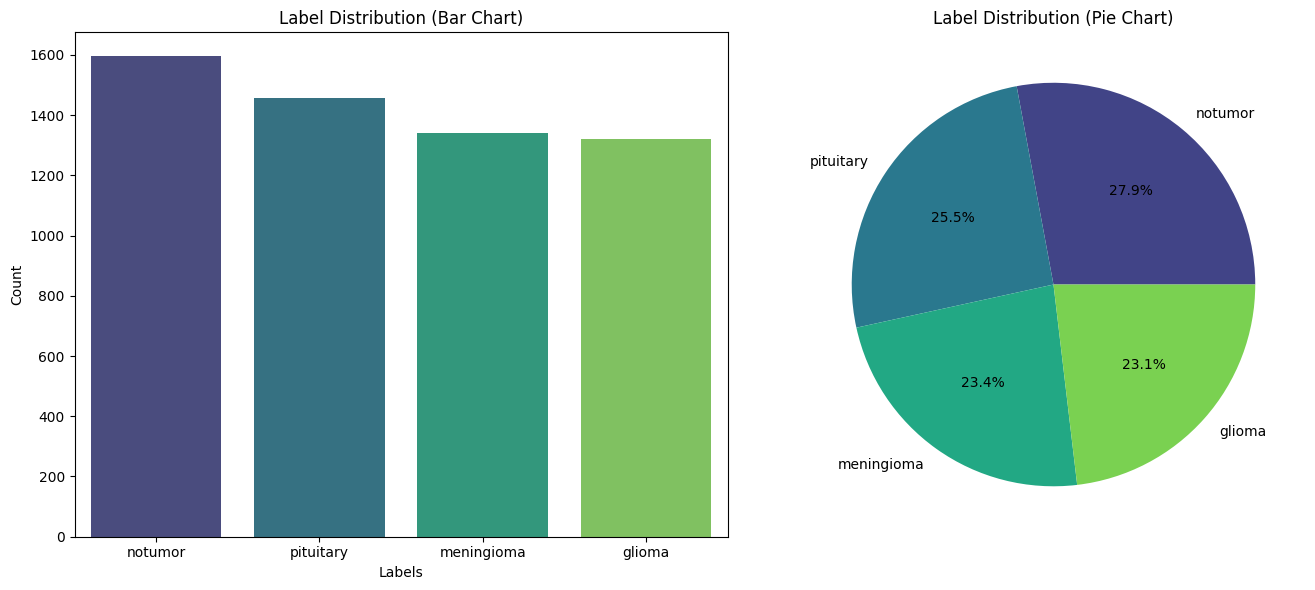

In [53]:
label_counts = train_df["label"].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(x=label_counts.index, y=label_counts.values, ax=axes[0], palette="viridis")
axes[0].set_title("Label Distribution (Bar Chart)")
axes[0].set_xlabel("Labels")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis="x")

axes[1].pie(label_counts, labels=label_counts.index, autopct="%1.1f%%", colors=sns.color_palette("viridis", len(label_counts)))
axes[1].set_title("Label Distribution (Pie Chart)")

plt.tight_layout()
plt.show()

In [54]:
def get_image_size(image_path):
    img = cv2.imread(image_path)
    if img is not None:
        return img.shape[1], img.shape[0]
    return None, None 

train_df["width"], train_df["height"] = zip(*train_df["file_path"].apply(get_image_size))

train_df["aspect_ratio"] = train_df["width"] / train_df["height"]

train_df[["width", "height", "aspect_ratio"]].describe()

width       height  aspect_ratio
count  5712.000000  5712.000000   5712.000000
mean    451.563200   453.883754      0.994201
std     131.004291   124.779164      0.109435
min     150.000000   168.000000      0.644809
25%     441.000000   442.000000      1.000000
50%     512.000000   512.000000      1.000000
75%     512.000000   512.000000      1.000000
max    1920.000000  1446.000000      1.785714

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


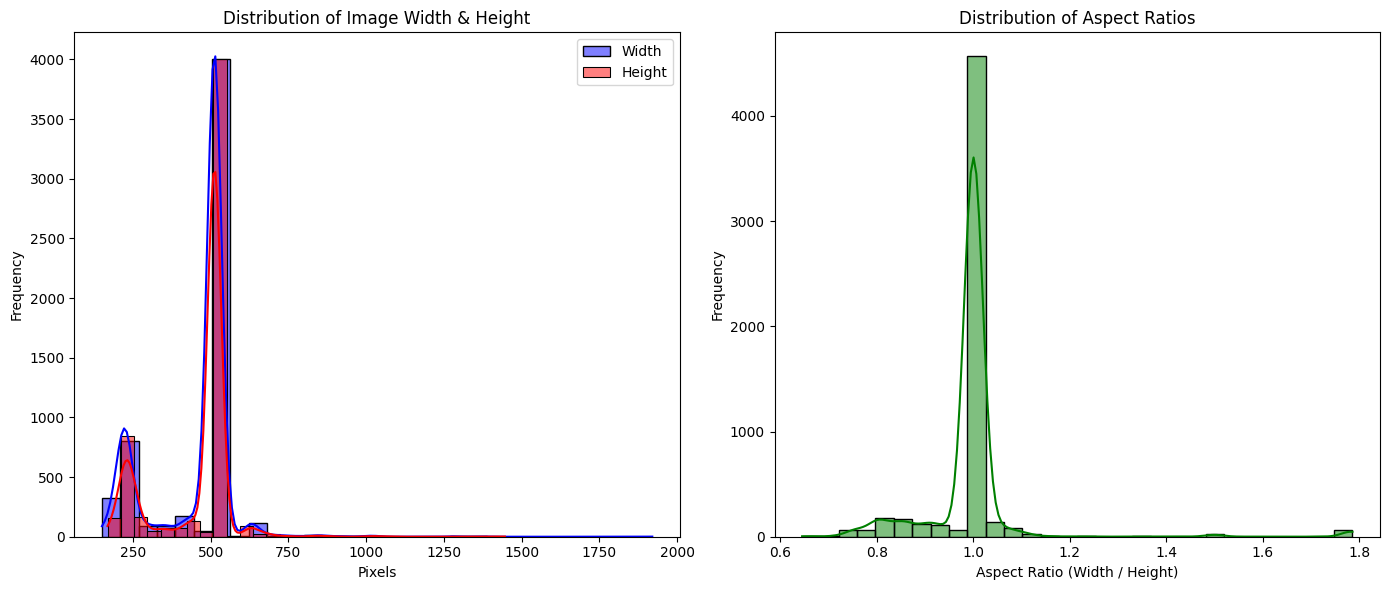

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# histogram of the image sizes
sns.histplot(train_df["width"], bins=30, kde=True, ax=axes[0], color="blue", label="Width")
sns.histplot(train_df["height"], bins=30, kde=True, ax=axes[0], color="red", label="Height")
axes[0].set_title("Distribution of Image Width & Height")
axes[0].set_xlabel("Pixels")
axes[0].set_ylabel("Frequency")
axes[0].legend()

# histogram of the aspect ratio
sns.histplot(train_df["aspect_ratio"], bins=30, kde=True, ax=axes[1], color="green")
axes[1].set_title("Distribution of Aspect Ratios")
axes[1].set_xlabel("Aspect Ratio (Width / Height)")
axes[1].set_ylabel("Frequency")

# Show plots
plt.tight_layout()
plt.show()

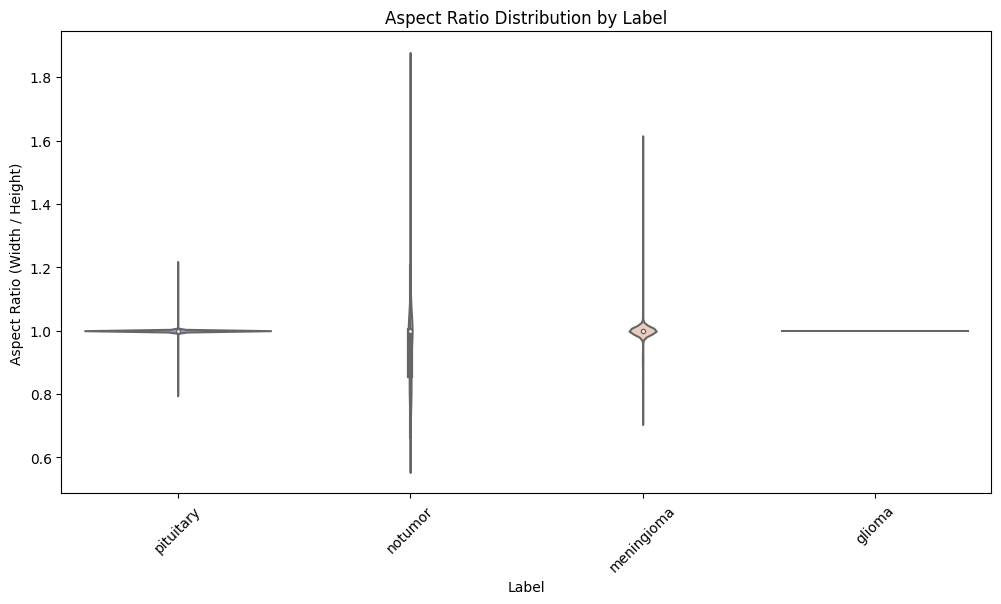

In [56]:
plt.figure(figsize=(12, 6))

sns.violinplot(x=train_df["label"], y=train_df["aspect_ratio"], palette="coolwarm")

plt.title("Aspect Ratio Distribution by Label")
plt.xlabel("Label")
plt.ylabel("Aspect Ratio (Width / Height)")
plt.xticks(rotation=45)

plt.show()

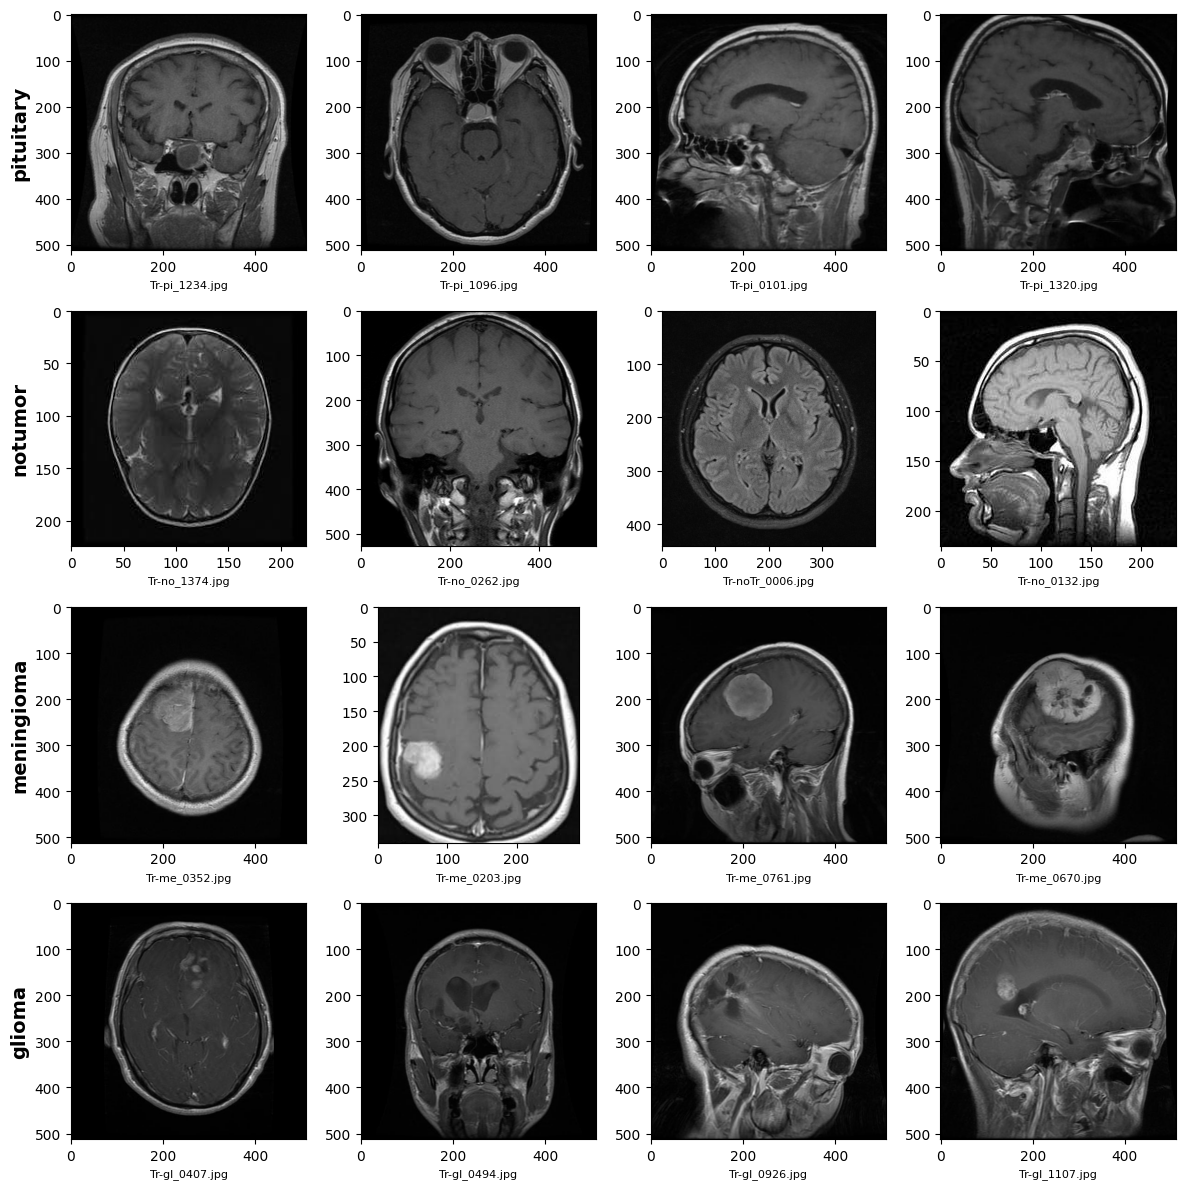

In [57]:
selected_labels = train_df["label"].unique()[:4]
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for row, label in enumerate(selected_labels):
    sample_paths = random.sample(train_df[train_df["label"] == label]["file_path"].tolist(), 4)
    
    for col, sample_path in enumerate(sample_paths):
        img = cv2.imread(sample_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        ax = axes[row, col]
        ax.imshow(img)
        
        if col == 0:
            ax.set_ylabel(label, fontsize=14, fontweight="bold") 
        
        img_name = os.path.basename(sample_path)
        ax.set_xlabel(img_name, fontsize=8, color="black")

plt.tight_layout()
plt.show()

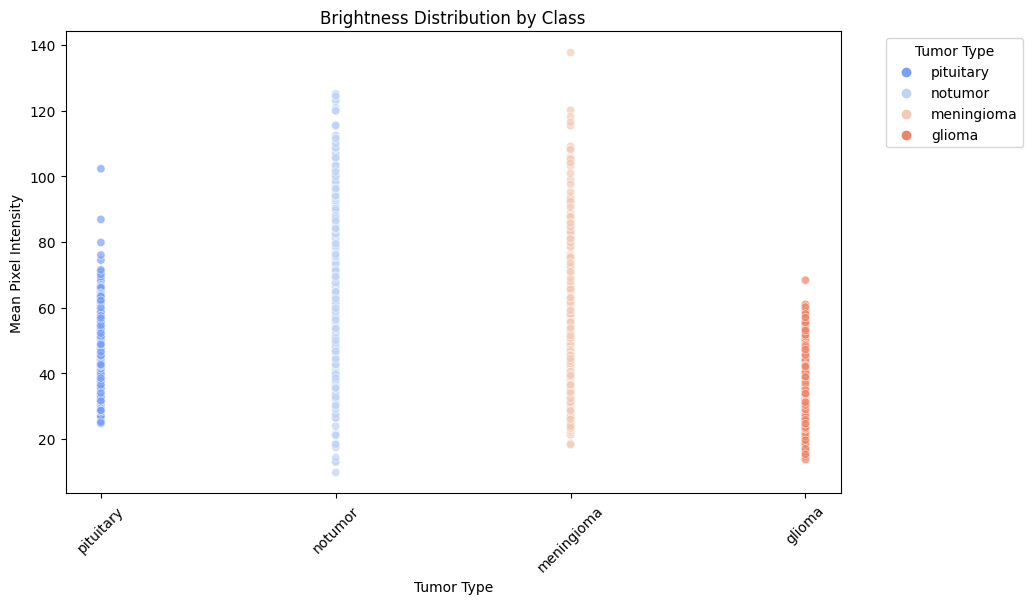

In [58]:
def compute_brightness(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return np.mean(img) if img is not None else None

train_df["brightness"] = train_df["file_path"].apply(compute_brightness)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_df["label"], y=train_df["brightness"], alpha=0.7, hue=train_df["label"], palette="coolwarm")
plt.title("Brightness Distribution by Class")
plt.xlabel("Tumor Type")
plt.ylabel("Mean Pixel Intensity")
plt.xticks(rotation=45)
plt.legend(title="Tumor Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

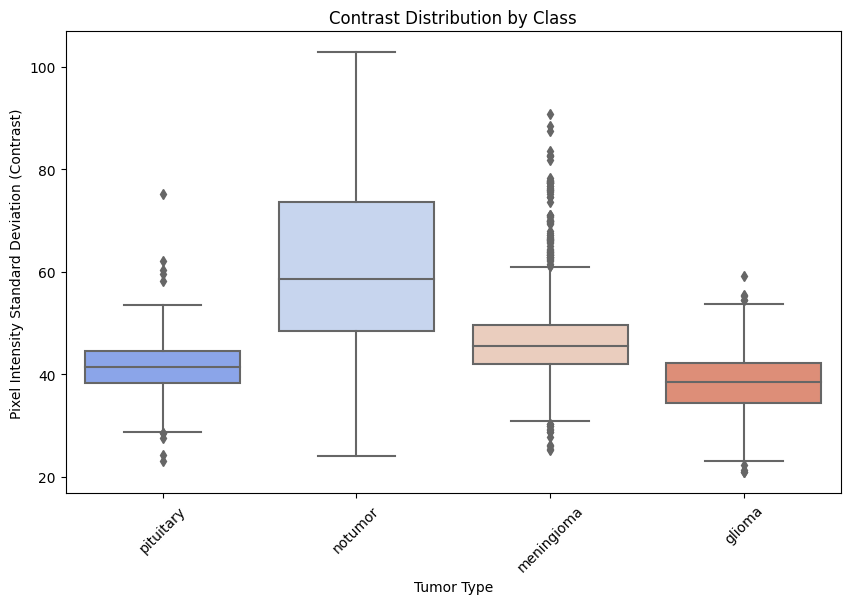

In [59]:
def compute_contrast(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return np.std(img) if img is not None else None

train_df["contrast"] = train_df["file_path"].apply(compute_contrast)

plt.figure(figsize=(10, 6))
sns.boxplot(x=train_df["label"], y=train_df["contrast"], palette="coolwarm")

plt.title("Contrast Distribution by Class")
plt.xlabel("Tumor Type")
plt.ylabel("Pixel Intensity Standard Deviation (Contrast)")
plt.xticks(rotation=45)
plt.show()

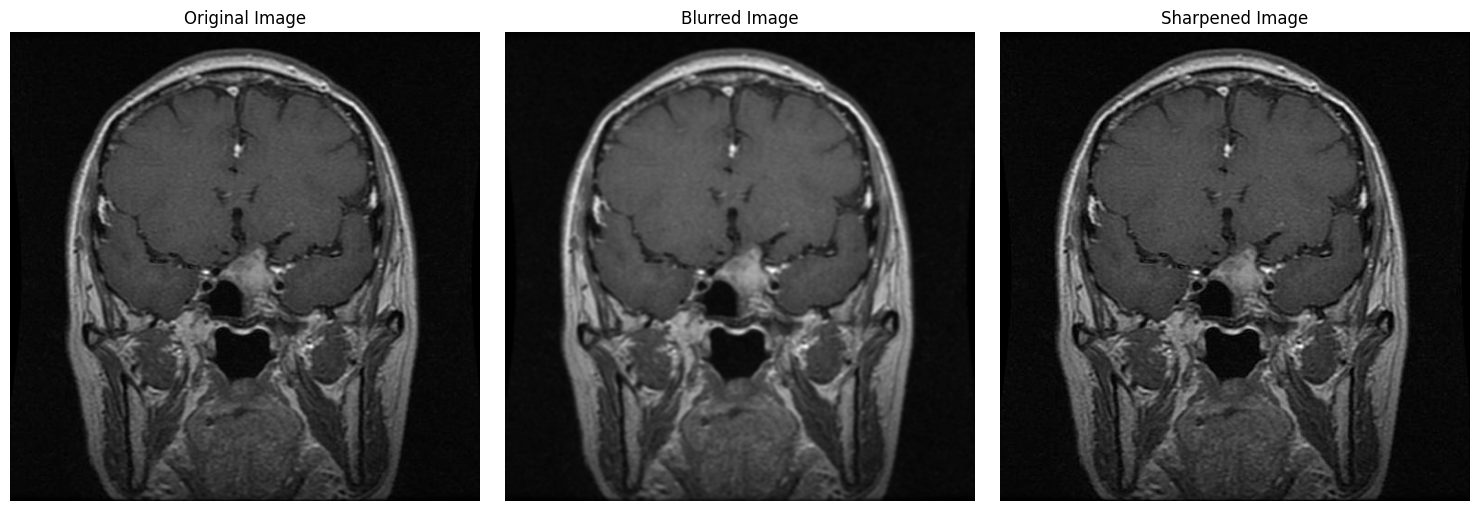

In [60]:
# image processing techniques

image_path = train_df.iloc[1, 0]
img = cv2.imread(image_path)

# Convert to grayscale for easier processing
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur
blurred = cv2.GaussianBlur(img_gray, (5, 5), 0)

# Subtract the blurred image from the original (sharpening)
sharpened = cv2.addWeighted(img_gray, 1.5, blurred, -0.5, 0)

# Plot the results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(img_gray, cmap='gray')
axes[0].set_title("Original Image")
axes[1].imshow(blurred, cmap='gray')
axes[1].set_title("Blurred Image")
axes[2].imshow(sharpened, cmap='gray')
axes[2].set_title("Sharpened Image")

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

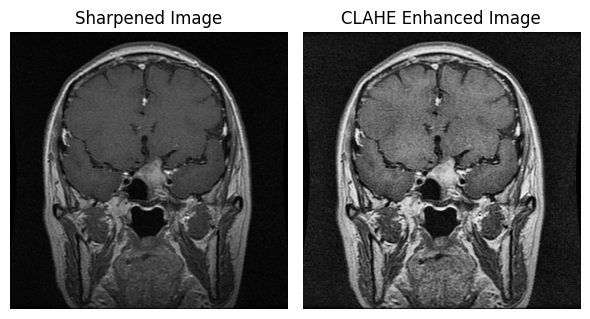

In [61]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
img_clahe = clahe.apply(sharpened)

# Plot the results
plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)
plt.imshow(sharpened, cmap='gray')
plt.title("Sharpened Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_clahe, cmap='gray')
plt.title("CLAHE Enhanced Image")
plt.axis('off')

plt.tight_layout()
plt.show()

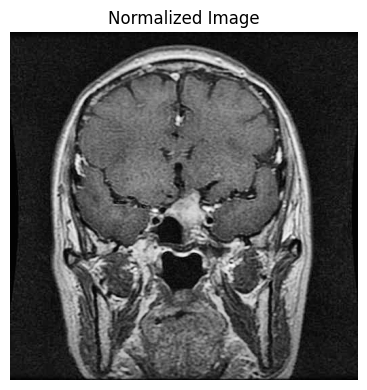

In [62]:
def z_score_normalization(mri_image):
    return (mri_image - np.mean(mri_image)) / np.std(mri_image)


normalized_img = z_score_normalization(img_clahe)

plt.figure(figsize=(12, 4))
plt.imshow(normalized_img, cmap='gray')
plt.title("Normalized Image")
plt.axis('off')

plt.tight_layout()
plt.show()

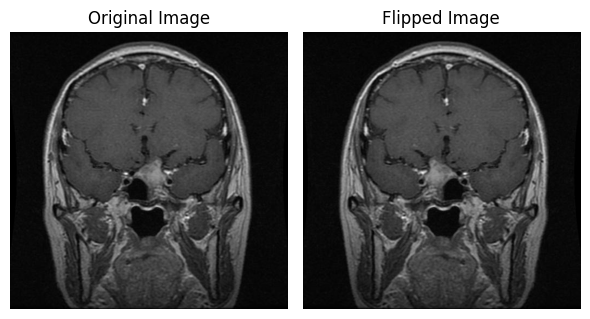

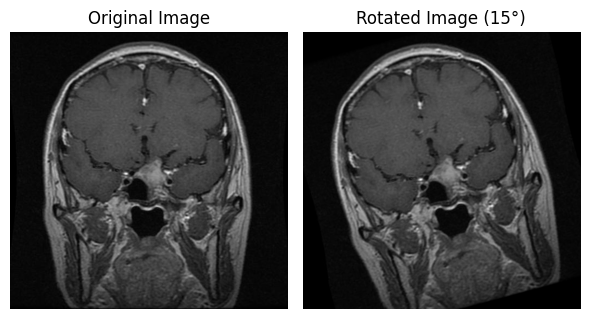

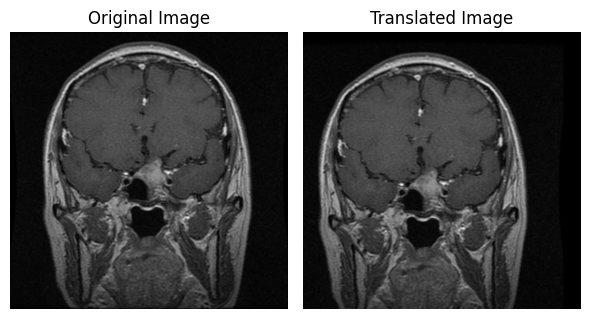

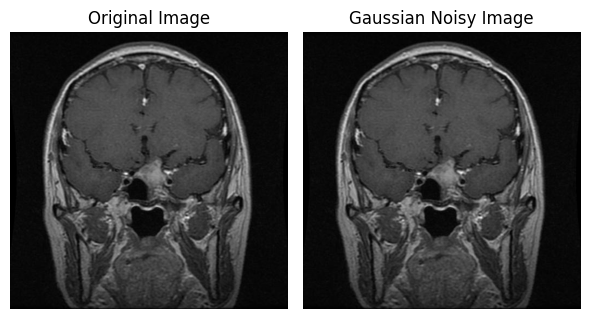

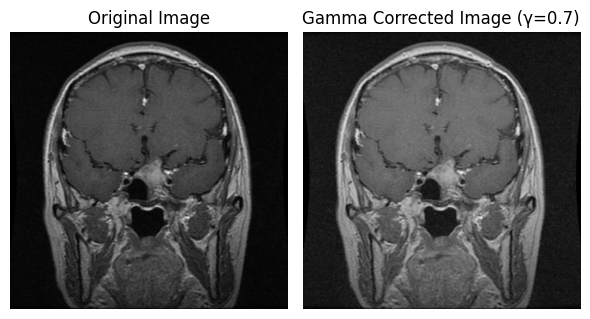

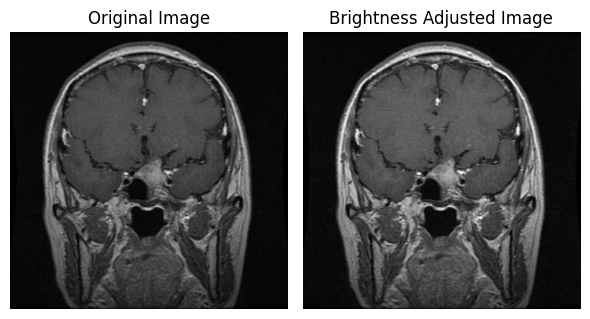

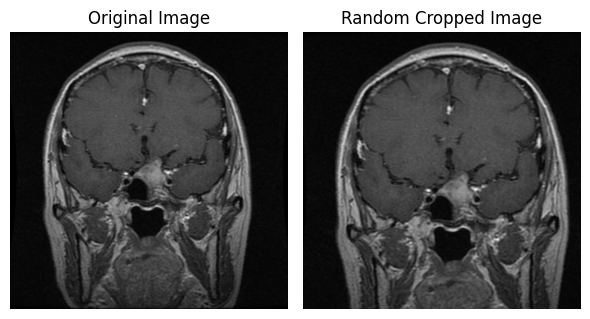

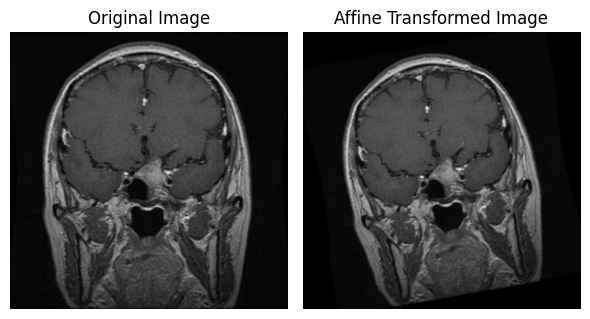

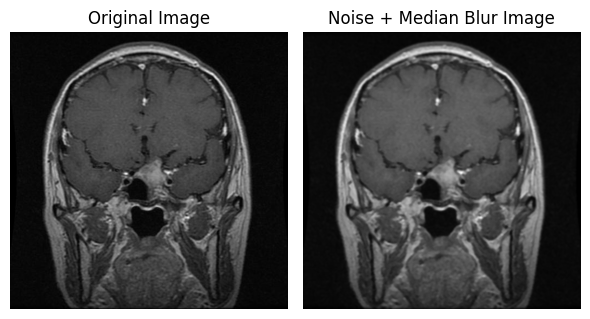

In [63]:
# Load MRI image (replace with your image path)
image_path = train_df.iloc[1, 0]
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Function to visualize transformations
def visualize_single_transformation(original, transformed, title):
    plt.figure(figsize=(6, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(transformed, cmap='gray')
    plt.title(title)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

### 1️⃣ Horizontal Flip ###
flipped = cv2.flip(img, 1)  # 1 means horizontal flip
visualize_single_transformation(img, flipped, "Flipped Image")

### 2️⃣ Rotation (±15 degrees) ###
angle = 15  # 15 degrees rotation
(h, w) = img.shape
center = (w // 2, h // 2)
M = cv2.getRotationMatrix2D(center, angle, 1.0)
rotated = cv2.warpAffine(img, M, (w, h))
visualize_single_transformation(img, rotated, "Rotated Image (15°)")

### 3️⃣ Translation (10% random shift) ###
tx, ty = np.random.randint(-int(w*0.1), int(w*0.1)), np.random.randint(-int(h*0.1), int(h*0.1))
M_translation = np.float32([[1, 0, tx], [0, 1, ty]])
translated = cv2.warpAffine(img, M_translation, (w, h))
visualize_single_transformation(img, translated, "Translated Image")

### 4️⃣ Gaussian Noise (σ=0.03) ###
noise = np.random.normal(0, 0.05, img.shape).astype(np.uint8)
gaussian_noisy = cv2.add(img, noise)
visualize_single_transformation(img, gaussian_noisy, "Gaussian Noisy Image")

### 5️⃣ Gamma Correction (γ=0.7) ###
gamma_corrected = np.array(255 * (img / 255) ** 0.7, dtype='uint8')
visualize_single_transformation(img, gamma_corrected, "Gamma Corrected Image (γ=0.7)")

### 6️⃣ Brightness Adjustment ###
brightness_factor = 40  # You can modify this to increase/decrease brightness
bright_img = cv2.add(img, brightness_factor)  # Increase brightness by adding constant value
visualize_single_transformation(img, bright_img, "Brightness Adjusted Image")

### 7️⃣ Random Cropping (85-95% ROI) ###
crop_size = np.random.randint(int(0.85 * img.shape[0]), int(0.95 * img.shape[0]))
crop_x = np.random.randint(0, img.shape[1] - crop_size)
crop_y = np.random.randint(0, img.shape[0] - crop_size)
cropped = img[crop_y:crop_y+crop_size, crop_x:crop_x+crop_size]
visualize_single_transformation(img, cropped, "Random Cropped Image")

### 8️⃣ Affine Stack (Rotation + Shift + Scale) ###
scale_factor = np.random.uniform(0.9, 1.1)
M_affine = cv2.getRotationMatrix2D(center, 10, scale_factor)
affine_transformed = cv2.warpAffine(img, M_affine, (w, h))
visualize_single_transformation(img, affine_transformed, "Affine Transformed Image")

### 9️⃣ Noise + Blur (Gaussian Noise + Median 3x3) ###
blurred = cv2.GaussianBlur(gaussian_noisy, (5, 5), 0)
median_blurred = cv2.medianBlur(blurred, 3)
visualize_single_transformation(img, median_blurred, "Noise + Median Blur Image")

### Data Preparation

---

In [64]:
# def preprocess_image(image_path, apply_aug=False):
#     """Load and preprocess an image with optional augmentation (TF-only)"""
#     # Read image as a byte tensor
#     img = tf.io.read_file(image_path)
#     img = tf.io.decode_jpg(img, channels=3)  # Ensure 3 channels (RGB)

#     # Resize while maintaining aspect ratio
#     img = resize_with_aspect_ratio(img, 224, 224)

#     # Apply augmentation to **only some images**
#     if apply_aug:
#         img = apply_random_augmentation(img)

#     # Normalize: Standardization
#     img = tf.image.per_image_standardization(img)

#     return img


# def process_tf_image(image_path, label, num_classes):
#     """TF wrapper for optimized image processing"""
#     apply_aug = tf.random.uniform(()) < 0.4  # Apply augmentation to ~40% of images
#     image = preprocess_image(image_path, apply_aug)
#     label = tf.one_hot(label, depth=num_classes, dtype=tf.float32)
#     return image, label


# def load_and_preprocess_from_df(df, num_classes, batch_size=32):
#     """Efficiently load dataset with reduced RAM usage"""
#     file_paths = df['file_path'].values
#     labels = df['label'].values

#     # Convert labels to indices
#     unique_labels = sorted(df['label'].unique())
#     label_to_index = {label: i for i, label in enumerate(unique_labels)}
#     int_labels = tf.convert_to_tensor([label_to_index[label] for label in labels], dtype=tf.int32)

#     dataset = tf.data.Dataset.from_tensor_slices((file_paths, int_labels))

#     # ✅ Efficient loading with parallel processing
#     dataset = dataset.map(lambda x, y: process_tf_image(x, y, num_classes),
#                           num_parallel_calls=tf.data.AUTOTUNE)

#     # ✅ Optimize shuffling and prefetching
#     dataset = dataset.shuffle(buffer_size=500).batch(batch_size).prefetch(tf.data.AUTOTUNE)

#     return dataset, label_to_index


# # ✅ Resize while keeping aspect ratio (TF-only)
# def resize_with_aspect_ratio(img, target_height, target_width):
#     """Resize while maintaining aspect ratio using TensorFlow."""
#     original_shape = tf.shape(img)
#     height = tf.cast(original_shape[0], tf.float32)
#     width = tf.cast(original_shape[1], tf.float32)
#     aspect_ratio = width / height

#     if aspect_ratio > 1:
#         new_width = target_width
#         new_height = tf.cast(target_width / aspect_ratio, tf.int32)
#     else:
#         new_height = target_height
#         new_width = tf.cast(target_height * aspect_ratio, tf.int32)

#     img_resized = tf.image.resize(img, [new_height, new_width], method=tf.image.ResizeMethod.AREA)
    
#     # Ensure final size is exactly (target_height, target_width)
#     img_resized = tf.image.resize_with_pad(img_resized, target_height, target_width)

#     return img_resized


# # ✅ Apply only **one** random augmentation (TF-only)
# def apply_random_augmentation(img):
#     augmentations = [
#         lambda x: tf.image.flip_left_right(x),  # Horizontal Flip
#         lambda x: rotate_image(x, angle=tf.random.uniform([], -10, 10)),  # Rotation
#         lambda x: translate_image(x, max_shift=0.05),  # Translation
#         lambda x: apply_gaussian_noise(x, std=0.03),  # Gaussian Noise
#         lambda x: adjust_gamma(x, gamma=tf.random.uniform([], 0.8, 1.2)),  # Gamma
#         lambda x: adjust_brightness(x, delta=tf.random.uniform([], -0.1, 0.1))  # Brightness
#     ]
#     return random.choice(augmentations)(img)


# # ✅ Image transformations (TF-only)
# def rotate_image(img, angle):
#     """Rotate image by a random angle (TF-only)"""
#     return tfa.image.rotate(img, angle * 3.1416 / 180)


# def translate_image(img, max_shift=0.05):
#     """Translate image randomly (TF-only)"""
#     shift_w = tf.random.uniform([], -max_shift, max_shift) * tf.cast(tf.shape(img)[1], tf.float32)
#     shift_h = tf.random.uniform([], -max_shift, max_shift) * tf.cast(tf.shape(img)[0], tf.float32)
#     return tfa.image.translate(img, [shift_w, shift_h])


# def apply_gaussian_noise(img, std=0.03):
#     """Apply Gaussian noise (TF-only)"""
#     noise = tf.random.normal(shape=tf.shape(img), mean=0.0, stddev=std)
#     return img + noise


# def adjust_gamma(img, gamma):
#     """Adjust gamma (TF-only)"""
#     return tf.image.adjust_gamma(img, gamma)


# def adjust_brightness(img, delta):
#     """Adjust brightness (TF-only)"""
#     return tf.image.adjust_brightness(img, delta)


# def resize_with_aspect_ratio(img, target_height, target_width):
#     """Resize an image while keeping its aspect ratio using TensorFlow."""
#     original_shape = tf.shape(img)
#     height = tf.cast(original_shape[0], tf.float32)
#     width = tf.cast(original_shape[1], tf.float32)
#     aspect_ratio = width / height

#     # Compute new size while maintaining aspect ratio
#     if aspect_ratio > 1:  # Wide image
#         new_width = target_width
#         new_height = tf.cast(target_width / aspect_ratio, tf.int32)
#     else:  # Tall or square image
#         new_height = target_height
#         new_width = tf.cast(target_height * aspect_ratio, tf.int32)

#     new_height = tf.minimum(new_height, target_height)
#     new_width = tf.minimum(new_width, target_width)
#     img_resized = tf.image.resize(img, [new_height, new_width], method=tf.image.ResizeMethod.AREA)
#     img_padded = tf.image.resize_with_pad(img_resized, target_height, target_width)

#     return img_padded


# def process_tf_image(image_path, label, num_classes):
#     """TensorFlow wrapper for optimized image processing"""
#     image = tf.py_function(preprocess_image, [image_path], tf.float32)
#     image.set_shape((224, 224, 3))  # Ensure TensorFlow knows the shape
#     label = tf.one_hot(label, depth=num_classes, dtype=tf.float32)
#     return image, label


# def load_and_preprocess_from_df(df, num_classes, batch_size=32):
#     """Efficiently load dataset with augmentation and reduced RAM usage"""
#     file_paths = df['file_path'].values
#     labels = df['label'].values

#     unique_labels = sorted(df['label'].unique())
#     label_to_index = {label: i for i, label in enumerate(unique_labels)}
#     int_labels = np.array([label_to_index[label] for label in labels], dtype=np.int32)

#     dataset = tf.data.Dataset.from_tensor_slices((file_paths, int_labels))

#     # Apply parallel image processing
#     dataset = dataset.map(lambda x, y: process_tf_image(x, y, num_classes),
#                           num_parallel_calls=tf.data.AUTOTUNE)

#     dataset = dataset.shuffle(500).batch(batch_size).prefetch(tf.data.AUTOTUNE)

#     return dataset, label_to_index

In [65]:
def preprocess_image(image_path):
    """Load and resize image to 256x256 using TensorFlow."""
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [128, 128])
    img = tf.image.per_image_standardization(img)
    return img

def process_tf_image(image_path, label, num_classes):
    """Load and preprocess an image while converting label to one-hot."""
    image = preprocess_image(image_path)
    label = tf.one_hot(label, depth=num_classes, dtype=tf.float32)
    return image, label

def load_and_preprocess_from_df(df, num_classes, batch_size=32):
    """Create a TensorFlow dataset from a DataFrame."""
    file_paths = df['file_path'].values
    labels = df['label'].values

    unique_labels = sorted(df['label'].unique())
    label_to_index = {label: i for i, label in enumerate(unique_labels)}
    int_labels = np.array([label_to_index[label] for label in labels], dtype=np.int32)

    dataset = tf.data.Dataset.from_tensor_slices((file_paths, int_labels))
    dataset = dataset.map(lambda x, y: process_tf_image(x, y, num_classes), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(len(train_df)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset, label_to_index

In [66]:
train_dataset, _ = load_and_preprocess_from_df(train_df, 4)
train_dataset = train_dataset.shuffle(buffer_size=500).prefetch(tf.data.AUTOTUNE)

In [67]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

### Simple CNN Model

---

In [68]:
# Custom Gaussian Noise Layer
class GaussianNoiseLayer(layers.Layer):
    def __init__(self, stddev=0.1, **kwargs):
        super(GaussianNoiseLayer, self).__init__(**kwargs)
        self.stddev = stddev

    def call(self, inputs, training=False):
        if training:
            noise = tf.random.normal(shape=tf.shape(inputs), mean=0.0, stddev=self.stddev)
            return inputs + noise
        return inputs

def build_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # Image augmentation layers
    x = layers.RandomFlip("horizontal")(inputs)  # Horizontal flip
    x = layers.RandomRotation(0.15)(x)  # Rotation between -15 and 15 degrees
    x = layers.RandomTranslation(0.1, 0.1)(x)  # Random translation
    x = layers.RandomZoom(0.1)(x)  # Random zoom
    x = layers.RandomContrast(0.2)(x)  # Random contrast adjustment
    
    # Additional augmentations
    x = layers.RandomBrightness(0.2)(x)  # Random brightness adjustment
    x = GaussianNoiseLayer(stddev=0.05)(x)  # Custom Gaussian noise layer
    
    # def jpeg_quality_augmentation(image):
    #     return tf.image.random_jpeg_quality(image, min_jpeg_quality=50, max_jpeg_quality=90)

    # x = layers.Lambda(lambda img: jpeg_quality_augmentation(img), output_shape=input_shape)(x)

    # ✅ CNN Feature Extraction with Batch Normalization
    x = layers.Conv2D(32, (3, 3), activation=None, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation=None, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation=None, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model


# Model compilation
model = build_model(input_shape=(128, 128, 3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip (RandomFlip)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_translation                   │ (None, 128, 128, 3)         │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_contrast (RandomContrast)     │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_brightness (RandomBrightness) │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gaussian_noise_layer                 │ (None, 128, 128, 3)         │               0 │
│ (GaussianNoiseLayer)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 32, 32, 128)         │              

 Total params: 4,289,604 (16.36 MB)

 Trainable params: 4,288,900 (16.36 MB)

 Non-trainable params: 704 (2.75 KB)

In [69]:
AUTOTUNE = tf.data.AUTOTUNE

val_size = int(0.2 * len(train_dataset))

train_dataset = train_dataset.skip(val_size)
val_dataset = train_dataset.take(val_size)

train_dataset = train_dataset.prefetch(AUTOTUNE)
val_dataset = val_dataset.prefetch(AUTOTUNE)

In [70]:
from tensorflow.keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [71]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_dataset,
    epochs=25,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

Epoch 1/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 19s 78ms/step - accuracy: 0.2442 - loss: 1.7635 - val_accuracy: 0.2473 - val_loss: 1.3772
Epoch 2/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.2727 - loss: 1.6329 - val_accuracy: 0.4103 - val_loss: 1.3045
Epoch 3/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 16s 79ms/step - accuracy: 0.3140 - loss: 1.5170 - val_accuracy: 0.5196 - val_loss: 1.0959
Epoch 4/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.3195 - loss: 1.4879 - val_accuracy: 0.4616 - val_loss: 1.1860
Epoch 5/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.3390 - loss: 1.4521 - val_accuracy: 0.4656 - val_loss: 1.0819
Epoch 6/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - accuracy: 0.3419 - loss: 1.3824 - val_accuracy: 0.5071 - val_loss: 1.0491
Epoch 7/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 16s 78ms/step - accuracy: 0.3300 - loss: 1.3915 - val_accuracy: 0.5482 - val_loss: 1.0198
Epoch 8/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 16s 79ms/step - accuracy: 0.3677 - loss: 1.3271 - 

In [72]:
def plot_training_curves(history):
    train_loss = history.history['loss']
    val_loss = history.history.get('val_loss')
    train_acc = history.history['accuracy']
    val_acc = history.history.get('val_accuracy')
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(14, 5))

    # Plot Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b', label='Training Loss')
    if val_loss:
        plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()

    # Plot Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
    if val_acc:
        plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()

    plt.show()

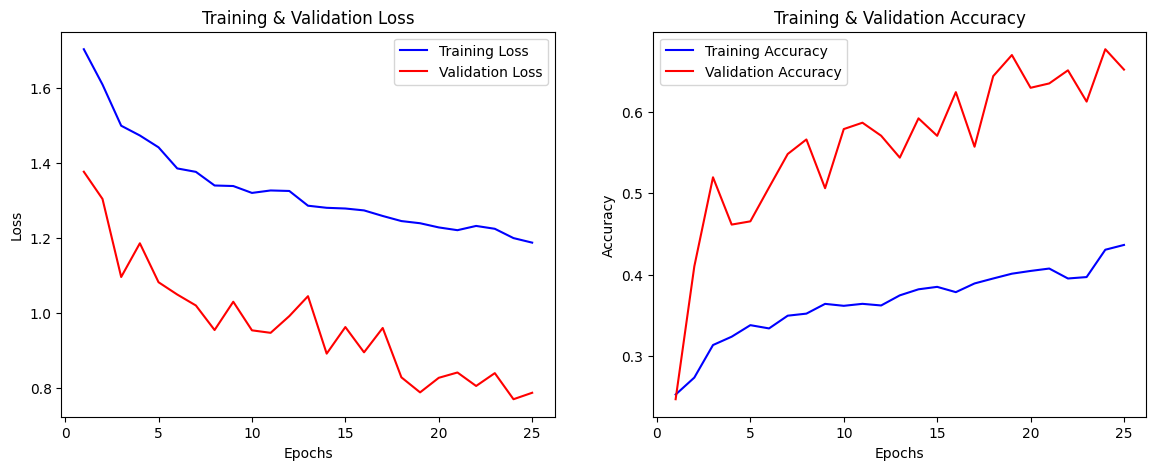

In [73]:
plot_training_curves(history)
tf.keras.backend.clear_session(free_memory=True)

Surprisingly the validation results are much higher than the training results
- more number of layers and features
- lowering the dropout
- more aggressive image augmentation
- using cosine decay scheduler to reduce learning rate dynamically

In [96]:
def build_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # Image augmentation layers
    x = layers.RandomFlip("horizontal")(inputs)  # Horizontal flip
    x = layers.RandomRotation(0.15)(x)  # Rotation between -15 and 15 degrees
    x = layers.RandomTranslation(0.1, 0.1)(x)  # Random translation
    x = layers.RandomZoom(0.1)(x)  # Random zoom
    x = layers.RandomContrast(0.2)(x)  # Random contrast adjustment
    
    # Additional augmentations
    x = layers.RandomBrightness(0.2)(x)  # Random brightness adjustment
    x = GaussianNoiseLayer(stddev=0.05)(x)  # Custom Gaussian noise layer
    # x = layers.Lambda(batch_jpeg_quality_augmentation)(x)  

    # 🟢 **Feature Extraction - Deeper & Wider Network**
    x = layers.Conv2D(64, (3, 3), activation=None, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation=None, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(256, (3, 3), activation=None, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(512, (3, 3), activation=None, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

In [97]:
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-3, decay_steps=10000, alpha=1e-5
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model = build_model(input_shape=(128, 128, 3))

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=0.1)

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['accuracy']
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_1 (RandomFlip)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_1 (RandomRotation)   │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_translation_1                 │ (None, 128, 128, 3)         │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_1 (RandomZoom)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_contrast_1 (RandomContrast)   │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_brightness_1                  │ (None, 128, 128, 3)         │               0 │
│ (RandomBrightness)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gaussian_noise_layer_1               │ (None, 128, 128, 3)         │               0 │
│ (GaussianNoiseLayer)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_5 (ReLU)                       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_6 (ReLU)                       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 9,945,732 (37.94 MB)

 Trainable params: 9,943,300 (37.93 MB)

 Non-trainable params: 2,432 (9.50 KB)

Epoch 1/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 26s 130ms/step - accuracy: 0.2438 - loss: 1.7325 - val_accuracy: 0.2328 - val_loss: 1.7952
Epoch 2/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 22s 125ms/step - accuracy: 0.2439 - loss: 1.5376 - val_accuracy: 0.2821 - val_loss: 1.3965
Epoch 3/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 23s 132ms/step - accuracy: 0.2540 - loss: 1.5078 - val_accuracy: 0.2902 - val_loss: 1.3837
Epoch 4/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 23s 130ms/step - accuracy: 0.2492 - loss: 1.4847 - val_accuracy: 0.2188 - val_loss: 1.3881
Epoch 5/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.2735 - loss: 1.4285 - val_accuracy: 0.2580 - val_loss: 1.4046
Epoch 6/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.2665 - loss: 1.4189 - val_accuracy: 0.2455 - val_loss: 1.3937
Epoch 7/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - accuracy: 0.2641 - loss: 1.4251 - val_accuracy: 0.2562 - val_loss: 1.3859
Epoch 8/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - accuracy: 0.2631 - loss: 1

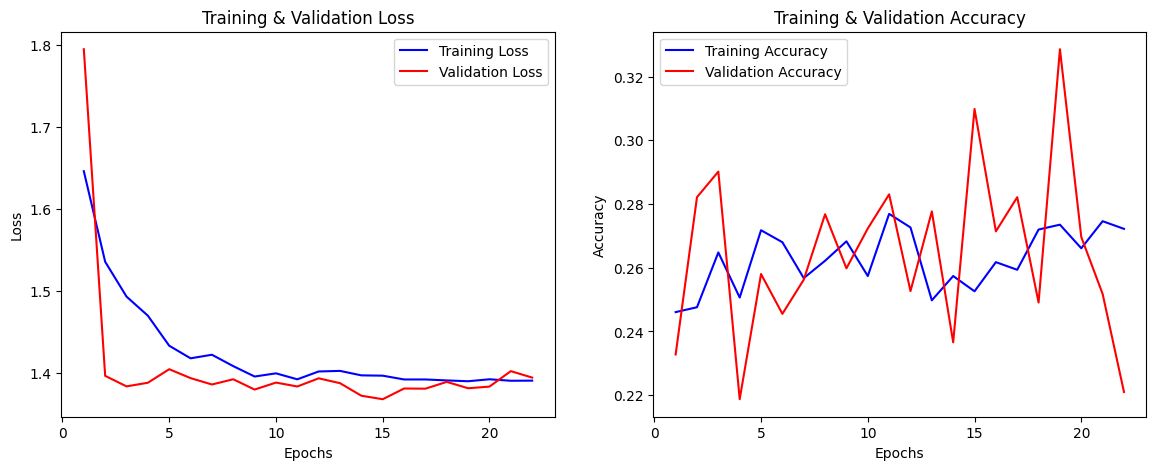

In [98]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    train_dataset,
    epochs=25,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)


plot_training_curves(history)

### EfficientNet model fine tuning

---

In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
import tensorflow.keras.applications as applications

def build_efficientnet_model(input_shape, num_classes):
    base_model = applications.EfficientNetB0(
        weights='imagenet',  # Load pretrained weights
        include_top=False,   # Exclude original classification head
        input_shape=input_shape
    )

    # 🔹 Freeze base model layers (prevents overfitting)
    base_model.trainable = False

    # 🔹 Custom classifier head
    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs, training=False)  # Use pretrained features
    x = layers.GlobalAveragePooling2D()(x)  # Reduce dimensions
    x = layers.Dropout(0.5)(x)  # Regularization
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)  # Prevent overfitting
    outputs = layers.Dense(num_classes, activation='softmax')(x)  # Multi-class classification

    model = models.Model(inputs, outputs)
    return model

In [ ]:
input_shape = (224, 224, 3)
num_classes = 4
model = build_efficientnet_model(input_shape, num_classes)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

In [ ]:
epochs = 20
batch_size = 32

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    batch_size=batch_size
)

### Performance Comparison

---